## Loading data

The train and test inputs are composed of 46 features.

The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [4]:
import pandas as pd
import os
import git

# Get the path of the current directory
path = os.getcwd()
# Get the absolute path of the git repo
repo = git.Repo(path, search_parent_directories=True).git.rev_parse("--show-toplevel")

x_train_path = os.path.join(repo, 'data', 'QRT', 'x_train_Lafd4AH.csv')
y_train_path = os.path.join(repo, 'data', 'QRT', 'y_train_JQU4vbI.csv')
x_test_path = os.path.join(repo, 'data', 'QRT', 'x_test_c7ETL4q.csv')

x_train = pd.read_csv(x_train_path, index_col='ID').fillna(0)

y_train = pd.read_csv(y_train_path, index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv(x_test_path, index_col='ID')
train.head()

0.4989213917987554

## Feature Engineering

The main drawback in this challenge would be to deal with the noise. To do that, we could create some feature that aggregate features with some statistics. 

The following cell computes statistics on a given target conditionally to some features. For example, we want to generate a feature that describe the mean of `RET_1` conditionally to the `SECTOR` and the `DATE`.

**Ideas of improvement**: 
- (From QRT) change shifts, the conditional features, the statistics, and the target.
- Fit a logistic regression or EMA to have a trend, on each category and subcategory, sector and so on
- Look at the ACF and PACF, of each stock and each category, maybe use an ARIMA model 

In [21]:
# Feature engineering
new_features = []

# Conditional aggregated features
shifts = [1]  # Choose some different shifts
statistics = ['mean']  # the type of stat
gb_features = ['SECTOR', 'DATE']
target_features = ['RET', 'VOLUME']
tmp_name = '_'.join(gb_features)
for target_feature in target_features:
    for shift in shifts:
        for stat in statistics:
            name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
            feat = f'{target_feature}_{shift}'
            new_features.append(name)
            for data in [train, test]:
                data[name] = data.groupby(gb_features)[feat].transform(stat)

train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET,RET_1_SECTOR_DATE_mean,VOLUME_1_SECTOR_DATE_mean
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True,0.009178,0.006680
1,0,3,43,15,6,104,0.003984,0.000000,-0.090580,0.000000,...,0.000000,-0.018518,0.000000,-0.028777,0.000000,-0.034722,0.000000,True,0.006477,0.009289
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False,0.013419,0.121380
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False,0.017253,-0.121974
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False,0.006241,-0.186348


In [22]:
import numpy as np
from sklearn.linear_model import LinearRegression

for feat in ['RET', 'VOLUME']:
    name = f'SECTOR_DATE_{feat}'
    new_features.append(name)
    # Conditional aggregated features
    for data in [train, test]:
        unique_sectors = data['SECTOR'].unique()
        unique_date = data['DATE'].unique()

        for sector in unique_sectors:
            for date in unique_date:

                data_ret = data[(data['SECTOR'] == sector) & (data['DATE'] == date)]
                selected_columns = [col for col in data_ret.columns if len(col.split('_')) == 2 and col.startswith(f'{feat}_')]
                data_ret = data_ret[selected_columns].fillna(0)

                num_lags = len(data_ret.columns)
                num_samples = len(data_ret)
                if num_samples > 0:
                    x = []
                    y = []
                    for i in range(num_lags):
                        j = num_lags - i
                        x += [i] * num_samples
                        y+= data_ret[f'{feat}_{j}'].values.tolist()

                    x = np.array(x).reshape(-1, 1)
                    y = np.array(y).reshape(-1)

                    model = LinearRegression()
                    model.fit(x, y)

                    data.loc[(data['SECTOR'] == sector) & (data['DATE'] == date), name] = model.predict(np.array(num_lags).reshape(1,1)).squeeze()

print(new_features)
train.head()


['RET_1_SECTOR_DATE_mean', 'VOLUME_1_SECTOR_DATE_mean', 'SECTOR_DATE_RET', 'SECTOR_DATE_VOLUME']


,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET,RET_1_SECTOR_DATE_mean,VOLUME_1_SECTOR_DATE_mean,SECTOR_DATE_RET,SECTOR_DATE_VOLUME
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True,0.009178,0.006680,0.002551,-0.174754
1,0,3,43,15,6,104,0.003984,0.000000,-0.090580,0.000000,...,0.000000,-0.028777,0.000000,-0.034722,0.000000,True,0.006477,0.009289,0.000564,-0.122466
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False,0.013419,0.121380,0.003309,0.189540
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False,0.017253,-0.121974,-0.000285,-0.308088
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.017547,0.004256,0.579510,-0.040817,0.802806,False,0.006241,-0.186348,0.000407,-0.082580


## Feature selection

To reduce the number of feature (and the noise) we only consider the 5 last days of `RET` and `VOLUME` in addition to the newly created feature.

In [27]:
target = 'RET'

n_shifts = 5  # If you don't want all the shifts to reduce noise
features = [f'RET_{i+1}' for i in range(n_shifts)]
features += [f'VOLUME_{i+1}'  for i in range(n_shifts)]
features += new_features  # The conditional features
train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,RET_1_SECTOR_DATE_mean,VOLUME_1_SECTOR_DATE_mean,SECTOR_DATE_RET,SECTOR_DATE_VOLUME
ID,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920,0.009178,0.006680,0.002551,-0.174754
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,0.000000,0.000000,0.000000,0.000000,0.000000,0.006477,0.009289,0.000564,-0.122466
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455,0.013419,0.121380,0.003309,0.189540
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464,0.017253,-0.121974,-0.000285,-0.308088
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398,0.006241,-0.186348,0.000407,-0.082580


## Model and local score

A Random Forest (RF) model is chosen for the Benchmark. We consider a large number of tree with a quiet small depth. The missing values are simply filled with 0. A KFold is done on the dates (using `DATE`) for a local scoring of the model. 

**Ideas of improvements**: Tune the RF hyperparameters, deal with the missing values, change the features, consider another model, ...

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import KFold
import numpy as np
from tqdm import tqdm

X_train = train[features]
y_train = train[target]

# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    # 'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    # 'n_jobs': -1
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in tqdm(enumerate(splits)):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = HistGradientBoostingClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

0it [00:00, ?it/s]

1it [00:02,  2.02s/it]

Fold 1 - Accuracy: 51.56%


2it [00:04,  2.18s/it]

Fold 2 - Accuracy: 50.85%


3it [00:06,  2.10s/it]

Fold 3 - Accuracy: 51.09%


4it [00:08,  2.13s/it]

Fold 4 - Accuracy: 52.19%
Accuracy: 51.42% [50.92 ; 51.93] (+- 0.51)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


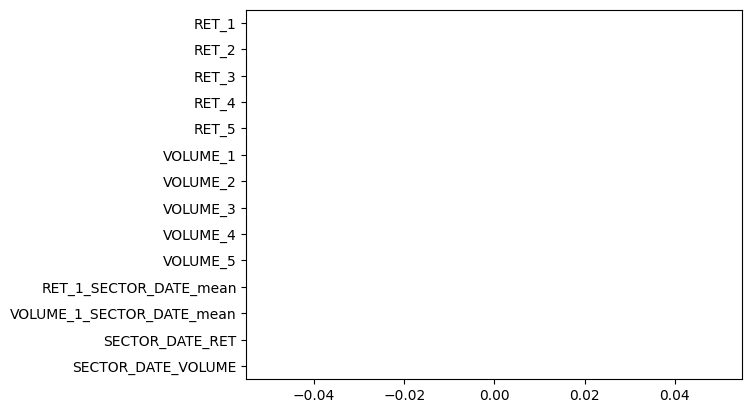

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.barplot(data=feature_importances, orient='h')#, order=feature_importances.mean().sort_values(ascending=False).index)
plt.show()

## Generate the submission

The same parameters of the RF model are considered. With that we build a new RF model on the entire `train` dataset. The predictions are saved in a `.csv` file.

In [26]:
X_test = test[features]

rf_params['random_state'] = 0
model = RandomForestClassifier(**rf_params)
model.fit(X_train.fillna(0), y_train)
y_pred = model.predict_proba(X_test.fillna(0))[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./benchmark_qrt.csv', index=True, header=True)